In [1]:
import numpy as np
import pandas as pd

In [2]:
true_effect = 2

Y = np.random.normal(0,1,9)
Y = np.append(Y, np.random.normal(true_effect,1,1)[0])

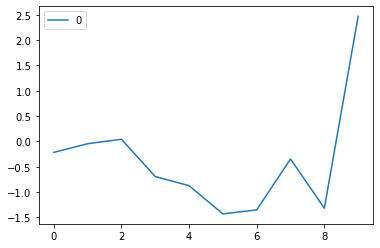

In [3]:
pd.DataFrame(Y).plot()

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [5]:
def h0_outcome(Y,effect):
    sample_size = len(Y)
    boot = np.random.choice(Y[:-1],sample_size)
    boot[-1] = boot[-1]+effect
    
    pre_mean = boot[:-1].mean()
    pre_sd = boot[:-1].std()
    est_effect = boot[-1]-pre_mean
    
    if est_effect < 1.65*pre_sd/np.sqrt(sample_size):
        return 0.0
    else:
        return est_effect

    
def h0_bias(Y,effect,no_sims):
    sim_df = pd.DataFrame(columns =['sim','est_effect'])
    sim_df['sim'] = range(1,no_sims)
    sim_df['est_effect'] = sim_df['sim'].apply(lambda s: h0_outcome(Y,effect) )
    
    rejected_mean = sim_df[['est_effect']].query('est_effect !=0').mean()[0]
    return rejected_mean

def h0_bias_range(Y,no_sims, lower,upper):
    bias_df = pd.DataFrame(columns = ['effect','biased_effect'])
    bias_df['effect'] = np.linspace(lower,upper,25)
    bias_df['biased_effect'] = bias_df['effect'].apply(lambda s: h0_bias(Y,s,no_sims))
    
    return bias_df

def true_effect_est(Y,lower,upper,no_sims):
    est_effect = Y[-1]-Y[:-1].mean()
    
    bias_df = h0_bias_range(Y,no_sims,lower,upper)
    
    closest_est = find_nearest( bias_df['biased_effect'], est_effect)
    de_biased_est = bias_df[ bias_df['biased_effect'] == closest_est]['effect'].values[0]
    return de_biased_est

In [6]:
print(true_effect_est(Y,0,3,2000))
print(Y[-1] - Y[:-1].mean() )
print(true_effect)

3.0
3.1625916396393867
2


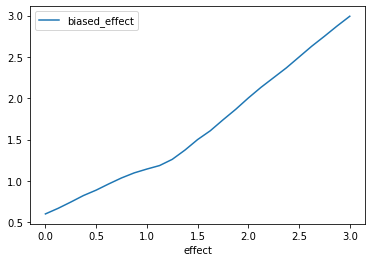

In [7]:
h0_bias_range(Y,2000,0,3).plot(x='effect',y='biased_effect')